## Two-level classification with classic machine learning and ensembles
The idea of this notebook is to demonstrate how to test different algorithms with hyperparameter tuning to train a model and how to evaluate a model that has two-level architecture which is a redacted version on my work on a very specific dataset on a totally unrelated topic.

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

### 1. Dataset Preparation steps

In [2]:
# Download IRIS dataset for classification problem
from sklearn import datasets
iris = datasets.load_iris()

# Display the DataFrame
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target)

df = pd.concat([x, y], axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),0
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
df = df.rename(columns = {0:'species'})

In [4]:
print(df.columns.tolist())

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']


In [5]:
# If we need to remove any unwanted columns
param_to_remove = ['sepal length (cm)', 'sepal length (cm)']
for col in df.columns.tolist():
    if '(c' in col or 'm)' in col:
        param_to_remove.append(col)

others_to_remove = []

remove_list = param_to_remove + others_to_remove

In [6]:
df.drop(remove_list, axis=1, inplace=True)
print(df.columns.tolist())

['species']


In [7]:
# Reload the DataFrame
# Display the DataFrame
x = pd.DataFrame(iris.data, columns = iris.feature_names)
y = pd.DataFrame(iris.target)

df = pd.concat([x, y], axis=1)
df = df.rename(columns = {0:'species'})
df.shape

(150, 5)

In [8]:
# adding three more random label columns
num_rows = df.shape[0]

new_cols = {'Label_1': np.random.choice(['A', 'B', 'C', 'D'], size=num_rows),
            'Label_2': np.random.choice(['A2', 'A2', 'C', 'D'], size=num_rows),
            'Label_3': np.random.choice(['B2', 'B', 'C', 'D'], size=num_rows)}

df = df.assign(**new_cols)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,5.1,3.5,1.4,0.2,0,C,A2,C
1,4.9,3.0,1.4,0.2,0,C,A2,B
2,4.7,3.2,1.3,0.2,0,C,C,C
3,4.6,3.1,1.5,0.2,0,A,D,D
4,5.0,3.6,1.4,0.2,0,B,C,B


In [9]:
# More columns and rows filtering can be done here, in the original data there are others
df["Label_2"] = df.apply(lambda x: 'A' if 'A' in x["Label_2"] else x["Label_2"], axis=1)
df["Label_3"] = df.apply(lambda x: 'B' if 'B' in x["Label_3"] else x["Label_3"], axis=1)

In [10]:
# check for null values, in this case there isn't any because it's a dummy dataset
print(df.columns[df.isnull().any()])

Index([], dtype='object')


In [11]:
#Create a new column that collects every labels that exist in a row (except when it's A) which will be used for stratification
key_types = ['species', 'Label_1', 'Label_2', 'Label_3']
df["labels"] = df.apply(lambda x: ','.join(x[x.index.isin(key_types)].index
                                           [x[x.index.isin(key_types)] != 'A' ]), axis=1)

#### Split the df into final_test_set and global_train_set using defect combination

In [12]:
# Find row with a unique combination of labels that only have one sample which will create problem during split
df["labels"].value_counts().loc[lambda x: x<2]

Series([], Name: labels, dtype: int64)

In [13]:
# Get the row that have unique combination (we will add them to the test set), before dropping them from the main df
unique_combination_ind = df["labels"].value_counts().loc[lambda x: x<2].index
unique_combination_df = df[df["labels"].isin(unique_combination_ind)]

#print(unique_combination_df)

# drop rows with unique_combination
print("before drop: ", df.shape)
df = df.drop(df[df["labels"].isin(unique_combination_ind)].index).reset_index(drop=True)
print("after drop: ", df.shape)

before drop:  (150, 9)
after drop:  (150, 9)


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["labels"]):
    Global_train_set = df.loc[train_index]
    Final_test_set_original = df.loc[test_index]

In [16]:
# Add the unique combination rows to the Final_test_set
Final_test_set_original = pd.concat([Final_test_set_original, unique_combination_df], ignore_index=True)

Final_test_set_original["labels"].value_counts()

species,Label_1,Label_3            11
species,Label_1,Label_2,Label_3    10
species,Label_3                     5
species,Label_2,Label_3             4
Name: labels, dtype: int64

In [17]:
# Drop the labels colmun from test and train sets
Global_train_set = Global_train_set.drop("labels", axis=1)
Final_test_set_original = Final_test_set_original.drop("labels", axis=1)

In [18]:
Global_train_set.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
32,5.2,4.1,1.5,0.1,0,B,C,B
145,6.7,3.0,5.2,2.3,2,A,A,C
78,6.0,2.9,4.5,1.5,1,B,A,B
34,4.9,3.1,1.5,0.2,0,D,D,D
93,5.0,2.3,3.3,1.0,1,D,A,B


#### End final test set split

# Classifier A training

### 2. Preparing the train set

In [19]:
df = Global_train_set.copy()

In [20]:
# Create the 'species_not_0' column where 0 for species is 0, and 1 is for the others
df["species_not_0"] = df.apply(lambda x: 0 if x['species'] == 0 else 1, axis=1)
#df[['Niv_Type','Nall_Type',"long_defect_cat"]]

In [21]:
# Drop the 'species' column
df.drop(['species']
        , axis=1, inplace=True)
print(df.columns.tolist())

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'Label_1', 'Label_2', 'Label_3', 'species_not_0']


In [22]:
# Find if there is any column that is not numeric 
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.head()

,Label_1,Label_2,Label_3
32,B,C,B
145,A,A,C
78,B,A,B
34,D,D,D
93,D,A,B


In [23]:
# Add categorical columns that are number manually can convert them to categorical type
other_cat_col = []
df[other_cat_col] = df[other_cat_col].astype("category")
df[other_cat_col].dtypes

Series([], dtype: object)

In [24]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [25]:
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
#print(df_cat_encoded)

df[df_cat.columns.tolist()] = df_cat_encoded
df[df_cat.columns.tolist()] = df[df_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

end of step 1.

### 3. Oversampling the train set

In [26]:
y_train = df["species_not_0"]
X_train = df.drop("species_not_0", axis=1)
y_train.value_counts()

1    83
0    37
Name: species_not_0, dtype: int64

In [27]:
#We check the ratio of the labels
df["species_not_0"].value_counts() / len(df)

1    0.691667
0    0.308333
Name: species_not_0, dtype: float64

We want more class 0 so use oversampling to make it 50:50

In [28]:
from collections import Counter
counter = Counter(y_train)
print('Before oversampling', counter)

Before oversampling Counter({1: 83, 0: 37})


In [29]:
oversampling = True

In [30]:
if oversampling:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy=0.8, random_state = 42) # sampling_strategy = float only works for Binary 
    
    X_train_pre_transf, y_train_pre_transf = smote.fit_resample(X_train, y_train)
    counter = Counter(y_train_pre_transf)
    print('After', counter)
else:
    X_train_pre_transf = X_train
    y_train_pre_transf = y_train

After Counter({1: 83, 0: 66})


In [31]:
#print(X_train_pre_transf[df_cat.columns.tolist()].value_counts())
X_train_pre_transf.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label_1,Label_2,Label_3
0,5.2,4.1,1.5,0.1,1.0,1.0,0.0
1,6.7,3.0,5.2,2.3,0.0,0.0,1.0
2,6.0,2.9,4.5,1.5,1.0,0.0,0.0
3,4.9,3.1,1.5,0.2,3.0,2.0,2.0
4,5.0,2.3,3.3,1.0,3.0,0.0,0.0


end of step 3.

### 4. Transformation

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer

In [33]:
X_train_set = X_train_pre_transf.copy()

In [34]:
cat_attribs = X_train_set.select_dtypes(include='category').columns.tolist()
#print(cat_attribs)

X_train_num_lst = X_train_set.drop(cat_attribs, axis=1).columns.tolist()
X_train_cat_lst = X_train_set[cat_attribs].columns.tolist()

print(X_train_num_lst)
print(X_train_cat_lst)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['Label_1', 'Label_2', 'Label_3']


In [35]:
# Create a transforamtion class to add, combine, fuse, extract features for the numeric PL
# stat_feature_head_to_tail is to use only the absolute 'ab_maximum' or 'average' value of each statistical features  
class Attrib_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, stat_features = 'ab_maximum'):
        self.stat_features = stat_features
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.stat_features is not None:
            stat_feature = ['sepal', 'petal']
            measurement = ['length', 'width']
            
            new_X = X.copy() # so the original df is not changed
            # See the commnad line argument and match it to pre-defined case 
            match self.stat_features:
                case 'ab_maximum':
                    for stat in stat_features:
                        meaurement_list= []
                        for measure in measurement:                            
                            # create a list of all measurement of each feature
                            temp = stat + ' ' + measure + ' (cm)'
                            meaurement_list.append(temp)
                            
                        
                        # Get the absolute maximum value of each row, keep the sign, and put them in a new colmun
                        col_name = measure + '_' + self.stat_features
                        row_max = X[meaurement_list].abs().max(axis=1)
                        new_X[col_name] = X[meaurement_list].max(axis=1).mask(lambda x: x < row_max, -row_max)
                        new_X = new_X.drop(meaurement_list, axis=1)
                
                case 'average':
                    for stat in stat_feature:
                        meaurement_list= []
                        for measure in measurement:                            
                            # create a list of all measurement of each feature
                            temp = stat + ' ' + measure + ' (cm)'
                            meaurement_list.append(temp)
                            
                        # Get the mean value of each row and put them in a new colmun 
                        col_name = measure + '_' + self.stat_features
                        new_X[col_name] = X[meaurement_list].mean(axis=1)
                        new_X = new_X.drop(meaurement_list, axis=1)
                    
                case _:   # 'case _' is for any other input that does not match None or the above
                    sys.exit("please choose from 'ab_maximum', 'average', or \
                    'None' for stat_featurs in Attrib_transformer")
                
            #print(list(new_X.columns))
            return new_X
            
        else:
            return X


In [36]:
# Create a transforamtion class to drop unwanted features
class Attrib_drop(BaseEstimator, TransformerMixin):
    def __init__(self, d_list=[], keep_only_length=False):
        self.d_list = d_list
        self.keep_only_length = keep_only_length
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.keep_only_length:
            Vert_acc_indices = []
            for i, col in enumerate(X.columns):
                if 'length' in col:
                    length_indices.append(i)
            return X.iloc[:,length_indices]
        elif self.d_list:
            keep_indices = []
            for i, col in enumerate(X.columns):
                if col not in self.d_list:
                    keep_indices.append(i)
            return X.iloc[:,keep_indices]
        else:
            return X

In [37]:
# List of the numerical features to be dropped to manually drop columns from the df
drop_list_num = [] # Here we can add columns that should be dropped from the df

num_pl = Pipeline([
    #('imputer', SimpleImputer(strategy="median")),
    ('attrib_transform', Attrib_transformer(stat_features='average')),
    ('attrib_drop', Attrib_drop(keep_only_length=False, d_list=drop_list_num)),
    ('std_scaler', StandardScaler()),
])

#For testing num_pl
#num_prep = num_pl.fit_transform(X_train_set[X_train_num_lst])
#print('shape after transformation: ', num_prep.shape)
#num_prep

In [38]:
# List of the categorical features to be dropped to manually drop columns from the df
drop_list_cat = []

cat_pl = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('attrib_drop', Attrib_drop()),
    ('One_Hot', OneHotEncoder(sparse_output=False)),
])

# For testing cat_pl
#cat_prep = cat_pl.fit_transform(X_train_set[X_train_cat_lst])
#cat_prep

In [39]:
full_pl = ColumnTransformer([
    ("num", num_pl, X_train_num_lst),
    ("cat", cat_pl, X_train_cat_lst),
])

X_train_prep = full_pl.fit_transform(X_train_set)

In [40]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (149, 14)


array([[-1.09411769,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18445742,  1.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.60515866,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.12328968,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-1.02843975,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.07155915,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

### 5. OPTIONAL: PCA for unsupervised feature selectiion

In [41]:
use_PCA = True

if use_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False)
    
    X_train_prep = pca.fit_transform(X_train_prep)
    print('number of components: ', pca.n_components_)

number of components:  8


In [42]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (149, 8)


array([[-0.90062185, -0.94296353,  0.26716972, ...,  0.88983501,
         0.6431283 , -0.21236745],
       [ 0.97135289,  1.15725043,  0.05315983, ..., -0.14821557,
         0.0224945 , -0.1105838 ],
       [ 0.6967494 ,  0.19485933,  0.37263395, ...,  0.79468589,
        -0.24998135, -0.27260727],
       ...,
       [-1.30149582,  0.70980351, -0.14071117, ...,  0.1686572 ,
         0.03813678,  0.34868833],
       [-1.08035326,  0.14609359, -0.47650836, ..., -0.58427179,
        -0.220518  , -0.11389437],
       [-1.27648926, -0.00352273, -0.39023199, ...,  0.17769844,
         0.29231219,  0.2104702 ]])

### 6. Tuning Base Classifier's hyper parameters

In [43]:
#pip install hyperopt

In [44]:
# using hyperopt for hyperparameter tuning
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope
from scipy import stats
from sklearn.model_selection import cross_val_score

# set number of randomised trial to carry out
n_iteration = 7

#This command can be used to randomly sample parameter set from a space
#from hyperopt.pyll.stochastic import sample as ho_sample
#ho_sample(space)

#### 6.1 SVM

In [45]:
from sklearn.svm import SVC

def tune_svm(params):
    svm_clf = SVC(**params['kernel'], C=params['C'])
    acc = cross_val_score(svm_clf, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2, n_jobs=-1).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "kernel": hp.choice("kernel",[
    {"kernel": 'linear', "gamma": 'scale'}, 
    {"kernel": 'poly', "gamma": hp.loguniform("gamma_poly", np.log(0.01), np.log(0.1))},
    {"kernel": 'rbf', "gamma": hp.loguniform("gamma_rbf", np.log(0.01), np.log(0.1))},
    {"kernel": 'sigmoid', "gamma": hp.loguniform("gamma_sigmoid", np.log(0.01), np.log(0.1))},
    ]),
    "C": hp.uniform("C", 1, 10),
}

trials=Trials() # Trails() must be reassign each time to reset its value
best_search_svm = fmin(fn=tune_svm, space=space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_svm = trials.best_trial
best_params_svm = best_trial_svm["misc"]["vals"]
best_score_svm = -best_trial_svm["result"]["loss"]

print("Best parameters:", best_params_svm)
print("Best score:", best_score_svm)

100%|████████████████████| 7/7 [00:06<00:00,  1.04trial/s, best loss: -1.0]
Best parameters: {'C': [2.9768507740063344], 'gamma_poly': [], 'gamma_rbf': [], 'gamma_sigmoid': [], 'kernel': [0]}
Best score: 1.0


In [46]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_svm)
final_params_svm = {
    'C': temp_params_dict['C'],
    'kernel': temp_params_dict['kernel']['kernel'],
    'gamma': temp_params_dict['kernel']['gamma'],
}

svm_clf = SVC(**final_params_svm)
svm_clf.fit(X_train_prep, y_train_pre_transf)

SVC(C=2.9768507740063344, kernel='linear')

#### 6.2 Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

def tune_LR(params):
    LR_clf = LogisticRegression(**params['solver'], C=params['C'], l1_ratio=params['l1_ratio'])
    acc = cross_val_score(LR_clf, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2, n_jobs=-1).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "solver": hp.choice("solver",[
    {"solver": 'newton-cg', "penalty": hp.choice("penalty_ncg", ['l2', None])}, 
    {"solver": 'lbfgs', "penalty": hp.choice("penalty_lbfgs", ['l2', None])},
    {"solver": 'saga', "penalty": hp.choice("penalty_saga", ['elasticnet', 'l1', 'l2', None])},
    ]),
    "C": hp.uniform("C", 1.0, 10.0),
    "l1_ratio": hp.uniform("l1_ratio", 0, 1),
}

trials=Trials() # Trails() must be reassign each time to reset its value
best_search_LR = fmin(fn=tune_LR, space = space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_LR = trials.best_trial
best_params_LR = best_trial_LR["misc"]["vals"]
best_score_LR = -best_trial_LR["result"]["loss"]

print("Best parameters:", best_params_LR)
print("Best score:", best_score_LR)

100%|████████████████████| 7/7 [00:00<00:00, 77.54trial/s, best loss: -1.0]
Best parameters: {'C': [7.9356614415364595], 'l1_ratio': [0.6253979211049021], 'penalty_lbfgs': [], 'penalty_ncg': [], 'penalty_saga': [0], 'solver': [2]}
Best score: 1.0


In [48]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_LR)
final_params_LR = {
    'C': temp_params_dict['C'],
    'solver': temp_params_dict['solver']['solver'],
    'penalty': temp_params_dict['solver']['penalty'],
    'l1_ratio': temp_params_dict['l1_ratio'] if temp_params_dict['solver']['penalty'] == 'elasticnet' else None,
}

LR_clf = LogisticRegression(**final_params_LR, n_jobs=-1)
LR_clf.fit(X_train_prep, y_train_pre_transf)

LogisticRegression(C=7.9356614415364595, l1_ratio=0.6253979211049021, n_jobs=-1,
                   penalty='elasticnet', solver='saga')

#### 6.3 Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

def tune_Tree(params):
    Tree_clf = DecisionTreeClassifier(**params)
    acc = cross_val_score(Tree_clf, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2, n_jobs=-1).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "max_features": hp.choice("max_features",['sqrt', 'log2', None]),
    "max_depth": hp.choice("max_depth",[5, 10, 15, None]),
    "criterion": hp.choice("criterion",['gini', 'entropy', 'log_loss']),
    "min_samples_leaf": hp.choice("min_samples_leaf", [1, 2, 3, 4, 5]),
}

trials=Trials() # Trails() must be reassign each time to reset its value
best_search_Tree = fmin(fn=tune_Tree, space = space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_Tree = trials.best_trial
best_params_Tree = best_trial_Tree["misc"]["vals"]
best_score_Tree = -best_trial_Tree["result"]["loss"]

print("Best parameters:", best_params_Tree)
print("Best score:", best_score_Tree)

100%|████████████████████| 7/7 [00:00<00:00, 27.32trial/s, best loss: -1.0]
Best parameters: {'criterion': [2], 'max_depth': [0], 'max_features': [2], 'min_samples_leaf': [0]}
Best score: 1.0


In [50]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_Tree)
final_params_Tree = {
    'max_features': temp_params_dict['max_features'],
    'max_depth': temp_params_dict['max_depth'],
    'criterion': temp_params_dict['criterion'],
    'min_samples_leaf': temp_params_dict['min_samples_leaf'],
}

Tree_clf = DecisionTreeClassifier(**final_params_Tree)
Tree_clf.fit(X_train_prep, y_train_pre_transf)

DecisionTreeClassifier(criterion='log_loss', max_depth=5)

#### 6.4 KNN Classifier

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def tune_KNN(params):
    KNN_clf = KNeighborsClassifier(**params, n_jobs=-1)
    acc = cross_val_score(KNN_clf, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2, n_jobs=-1).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "weights": hp.choice("weights",['uniform','distance']),
    "metric": hp.choice("metric",['minkowski','euclidean','manhattan']),
    "n_neighbors": scope.int(hp.uniform("n_neighbors", 3, 9)),
}

trials=Trials() # Trails() must be reassign each time to reset its value
best_search_KNN = fmin(fn=tune_KNN, space = space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_KNN = trials.best_trial
best_params_KNN = best_trial_KNN["misc"]["vals"]
best_score_KNN = -best_trial_KNN["result"]["loss"]

print("Best parameters:", best_params_KNN)
print("Best score:", best_score_KNN)

100%|█████| 7/7 [00:00<00:00, 55.45trial/s, best loss: -0.9933333333333334]
Best parameters: {'metric': [1], 'n_neighbors': [7.8073390279916435], 'weights': [1]}
Best score: 0.9933333333333334


In [52]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_KNN)
final_params_KNN = {
    'weights': temp_params_dict['weights'],
    'metric': temp_params_dict['metric'],
    'n_neighbors': temp_params_dict['n_neighbors'],
}

KNN_clf = KNeighborsClassifier(**final_params_KNN, n_jobs=-1)
KNN_clf.fit(X_train_prep, y_train_pre_transf)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=7,
                     weights='distance')

#### 6.5 MLP Classifier

In [53]:
from sklearn.neural_network import MLPClassifier

def tune_mlp(params):
    mlp_clf = MLPClassifier(**params['solver'], activation=params['activation'], 
                            hidden_layer_sizes=params['hidden_layer_sizes'], 
                            alpha=params['alpha'], max_iter=1500)
    acc = cross_val_score(mlp_clf, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2, n_jobs=-1).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "solver": hp.choice("solver",[
    {"solver": 'sgd', "learning_rate": hp.choice("learning_rate_sgd", ['constant','adaptive'])}, 
    {"solver": 'lbfgs', "learning_rate": 'constant'},
    {"solver": 'adam', "learning_rate": 'constant'},
    ]),
    "activation": hp.choice("activation",['tanh', 'relu']),
    "hidden_layer_sizes": hp.choice("hidden_layer_sizes",[(10,30,10),(20,)]),
    "alpha": hp.loguniform("alpha", np.log(0.0001), np.log(0.01)),
}

trials=Trials() # Trails() must be reassign each time to reset its value
best_search_mlp = fmin(fn=tune_mlp, space = space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_mlp = trials.best_trial
best_params_mlp = best_trial_mlp["misc"]["vals"]
best_score_mlp = -best_trial_mlp["result"]["loss"]

print("Best parameters:", best_params_mlp)
print("Best score:", best_score_mlp)

100%|████████████████████| 7/7 [00:01<00:00,  3.55trial/s, best loss: -1.0]
Best parameters: {'activation': [1], 'alpha': [0.00012774457443571184], 'hidden_layer_sizes': [0], 'learning_rate_sgd': [0], 'solver': [0]}
Best score: 1.0


In [54]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_mlp)
final_params_mlp = {
    'activation': temp_params_dict['activation'],
    'hidden_layer_sizes': temp_params_dict['hidden_layer_sizes'],
    'alpha': temp_params_dict['alpha'],       
    'solver': temp_params_dict['solver']['solver'],
    'learning_rate': temp_params_dict['solver']['learning_rate'],
}

mlp_clf = MLPClassifier(**final_params_mlp, max_iter=1500)
mlp_clf.fit(X_train_prep, y_train_pre_transf)

MLPClassifier(alpha=0.00012774457443571184, hidden_layer_sizes=(10, 30, 10),
              max_iter=1500, solver='sgd')

### 7. Ensemble techniques to improve model's performance

#### 7.1 as a reference RandomForest (which is a Bagging classifier of DT) from Scikit-learn is used

In [55]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(**final_params_Tree, n_jobs=-1)

rnd_clf.fit(X_train_prep, y_train_pre_transf)

RandomForestClassifier(criterion='log_loss', max_depth=5, max_features=None,
                       n_jobs=-1)

#### 7.2 Bagging classifier on best_model from the previous step

#### 7.3 CatBoost (DT based) becuase of good perofrmance with previous study

In [56]:
#pip install catboost

In [57]:
from catboost import CatBoostClassifier

def tune_CatB(params):
    CatB_clf = CatBoostClassifier(**params)
    acc = cross_val_score(CatB_clf, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "iterations": hp.choice("iterations",[30, 50, 70, 90, 100]),
    "depth": hp.choice("depth",[3, 5, 10, 15, None]),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.05), np.log(0.5)),
}


trials=Trials() # Trails() must be reassign each time to reset its value
best_search_CatB = fmin(fn=tune_CatB, space = space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_CatB = trials.best_trial
best_params_CatB = best_trial_CatB["misc"]["vals"]
best_score_CatB = -best_trial_CatB["result"]["loss"]

print("Best parameters:", best_params_CatB)
print("Best score:", best_score_CatB)

  0%|                                | 0/7 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.6730668	total: 160ms	remaining: 4.63s
1:	learn: 0.6400705	total: 161ms	remaining: 2.26s
2:	learn: 0.6236539	total: 166ms	remaining: 1.5s
3:	learn: 0.5988623	total: 169ms	remaining: 1.1s
4:	learn: 0.5870234	total: 179ms	remaining: 894ms
5:	learn: 0.5753086	total: 207ms	remaining: 827ms
6:	learn: 0.5642884	total: 232ms	remaining: 762ms
7:	learn: 0.5474858	total: 250ms	remaining: 686ms
8:	learn: 0.5364286	total: 260ms	remaining: 607ms
9:	learn: 0.5263388	total: 312ms	remaining: 624ms
10:	learn: 0.5138457	total: 315ms	remaining: 544ms
11:	learn: 0.5042311	total: 340ms	remaining: 510ms
12:	learn: 0.4916483	total: 343ms	remaining: 448ms
13:	learn: 0.4818616	total: 368ms	remaining: 420ms
14:	learn: 0.4704606	total: 397ms	remaining: 397ms
15:	learn: 0.4562683	total: 400ms	remaining: 350ms
16:	learn: 0.4442983	total: 407ms	remaining: 311ms
17:	learn: 0.4381351	total: 533ms	remaining: 355ms
18:	learn: 0.424364

 29%|█████▋              | 2/7 [00:03<00:08,  1.67s/trial, best loss: -1.0]0:	learn: 0.6812821	total: 10.2ms	remaining: 701ms
1:	learn: 0.6614002	total: 11.4ms	remaining: 386ms
2:	learn: 0.6512221	total: 15.3ms	remaining: 341ms
3:	learn: 0.6356339	total: 17.4ms	remaining: 286ms
4:	learn: 0.6279688	total: 22.7ms	remaining: 295ms
5:	learn: 0.6203130	total: 42.2ms	remaining: 450ms
6:	learn: 0.6130472	total: 63.9ms	remaining: 575ms
7:	learn: 0.6018404	total: 77.2ms	remaining: 599ms
8:	learn: 0.5943122	total: 84.3ms	remaining: 571ms
9:	learn: 0.5875572	total: 130ms	remaining: 779ms
10:	learn: 0.5788758	total: 133ms	remaining: 713ms
11:	learn: 0.5720932	total: 157ms	remaining: 761ms
12:	learn: 0.5631262	total: 161ms	remaining: 705ms
13:	learn: 0.5560367	total: 184ms	remaining: 735ms
14:	learn: 0.5476718	total: 207ms	remaining: 760ms
15:	learn: 0.5371820	total: 210ms	remaining: 709ms
16:	learn: 0.5281047	total: 217ms	remaining: 676ms
17:	learn: 0.5233416	total: 315ms	remaining: 911ms
18:	lear

18:	learn: 0.4839107	total: 261ms	remaining: 1.11s
19:	learn: 0.4763461	total: 268ms	remaining: 1.07s
20:	learn: 0.4671518	total: 270ms	remaining: 1.01s
21:	learn: 0.4618981	total: 290ms	remaining: 1.03s
22:	learn: 0.4557821	total: 299ms	remaining: 1000ms
23:	learn: 0.4507941	total: 308ms	remaining: 976ms
24:	learn: 0.4433059	total: 314ms	remaining: 941ms
25:	learn: 0.4367242	total: 331ms	remaining: 943ms
26:	learn: 0.4262715	total: 332ms	remaining: 898ms
27:	learn: 0.4187648	total: 334ms	remaining: 858ms
28:	learn: 0.4131882	total: 339ms	remaining: 829ms
29:	learn: 0.4092004	total: 401ms	remaining: 935ms
30:	learn: 0.4049877	total: 420ms	remaining: 935ms
31:	learn: 0.4000542	total: 459ms	remaining: 976ms
32:	learn: 0.3933979	total: 462ms	remaining: 938ms
33:	learn: 0.3888963	total: 467ms	remaining: 907ms
34:	learn: 0.3772279	total: 469ms	remaining: 870ms
35:	learn: 0.3733113	total: 491ms	remaining: 873ms
36:	learn: 0.3656042	total: 500ms	remaining: 852ms
37:	learn: 0.3622462	total: 52

81:	learn: 0.2210816	total: 1.55s	remaining: 341ms
82:	learn: 0.2175792	total: 1.55s	remaining: 319ms
83:	learn: 0.2157355	total: 1.57s	remaining: 300ms
84:	learn: 0.2139855	total: 1.6s	remaining: 283ms
85:	learn: 0.2127237	total: 1.66s	remaining: 270ms
86:	learn: 0.2097059	total: 1.67s	remaining: 249ms
87:	learn: 0.2023743	total: 1.67s	remaining: 227ms
88:	learn: 0.2011772	total: 1.75s	remaining: 217ms
89:	learn: 0.1989149	total: 1.76s	remaining: 195ms
90:	learn: 0.1969153	total: 1.76s	remaining: 174ms
91:	learn: 0.1943725	total: 1.76s	remaining: 153ms
92:	learn: 0.1921953	total: 1.76s	remaining: 133ms
93:	learn: 0.1884537	total: 1.76s	remaining: 113ms
94:	learn: 0.1867597	total: 1.78s	remaining: 93.6ms
95:	learn: 0.1854029	total: 1.79s	remaining: 74.5ms
96:	learn: 0.1841698	total: 1.82s	remaining: 56.4ms
97:	learn: 0.1773697	total: 1.82s	remaining: 37.2ms
98:	learn: 0.1746860	total: 1.82s	remaining: 18.4ms
99:	learn: 0.1726965	total: 1.83s	remaining: 0us
 57%|███████████▍        | 4/

 71%|██████████████▎     | 5/7 [00:13<00:05,  2.64s/trial, best loss: -1.0]0:	learn: 0.6235858	total: 2.6ms	remaining: 75.5ms
1:	learn: 0.5707769	total: 5.64ms	remaining: 79ms
2:	learn: 0.5220864	total: 8.48ms	remaining: 76.3ms
3:	learn: 0.4876174	total: 11.2ms	remaining: 72.6ms
4:	learn: 0.4379053	total: 13.6ms	remaining: 68.1ms
5:	learn: 0.3926339	total: 15.2ms	remaining: 60.9ms
6:	learn: 0.3373409	total: 16.1ms	remaining: 52.8ms
7:	learn: 0.3127321	total: 17.5ms	remaining: 48.2ms
8:	learn: 0.2955884	total: 19ms	remaining: 44.4ms
9:	learn: 0.2722871	total: 20.4ms	remaining: 40.8ms
10:	learn: 0.2527443	total: 21.9ms	remaining: 37.8ms
11:	learn: 0.2392964	total: 23.4ms	remaining: 35.1ms
12:	learn: 0.2287573	total: 25.4ms	remaining: 33.2ms
13:	learn: 0.2138597	total: 27.7ms	remaining: 31.6ms
14:	learn: 0.2078396	total: 30.1ms	remaining: 30.1ms
15:	learn: 0.1947562	total: 31.9ms	remaining: 27.9ms
16:	learn: 0.1855589	total: 33.6ms	remaining: 25.7ms
17:	learn: 0.1756625	total: 35.3ms	rema

In [58]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_CatB)
final_params_CatB = {
    'iterations': temp_params_dict['iterations'],
    'depth': temp_params_dict['depth'],
    'learning_rate': temp_params_dict['learning_rate'],
}

CatB_clf = CatBoostClassifier(**final_params_CatB)
CatB_clf.fit(X_train_prep, y_train_pre_transf)

0:	learn: 0.5722970	total: 2.35ms	remaining: 209ms
1:	learn: 0.4831194	total: 5.39ms	remaining: 237ms
2:	learn: 0.4104631	total: 7.57ms	remaining: 219ms
3:	learn: 0.3411130	total: 9.89ms	remaining: 213ms
4:	learn: 0.2962543	total: 11.9ms	remaining: 203ms
5:	learn: 0.2585746	total: 13.9ms	remaining: 194ms
6:	learn: 0.2259273	total: 15ms	remaining: 178ms
7:	learn: 0.1996826	total: 15.8ms	remaining: 162ms
8:	learn: 0.1828138	total: 16.7ms	remaining: 150ms
9:	learn: 0.1631520	total: 17.4ms	remaining: 139ms
10:	learn: 0.1462778	total: 18.4ms	remaining: 132ms
11:	learn: 0.1316622	total: 19.1ms	remaining: 124ms
12:	learn: 0.1213442	total: 19.8ms	remaining: 117ms
13:	learn: 0.1085612	total: 20.6ms	remaining: 112ms
14:	learn: 0.1002292	total: 21.3ms	remaining: 107ms
15:	learn: 0.0895213	total: 22.1ms	remaining: 102ms
16:	learn: 0.0832627	total: 23ms	remaining: 98.7ms
17:	learn: 0.0746330	total: 23.7ms	remaining: 94.7ms
18:	learn: 0.0699555	total: 24.4ms	remaining: 91.1ms
19:	learn: 0.0655018	to

#### 7.4 AdaBoost with the plot_model

#### 7.5 Voting of all base classifier as well as RandomForest and CatBoost

In [59]:
all_estimator = [('SVM', svm_clf), ('LR', LR_clf), ('DT', Tree_clf), ('KNN', KNN_clf), 
                 ('MLP', mlp_clf), ('Rand_Forest', rnd_clf), ('CatB', CatB_clf)]

In [60]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=all_estimator, voting='hard', n_jobs=-1)

voting_clf.fit(X_train_prep, y_train_pre_transf)

VotingClassifier(estimators=[('SVM',
                              SVC(C=2.9768507740063344, kernel='linear')),
                             ('LR',
                              LogisticRegression(C=7.9356614415364595,
                                                 l1_ratio=0.6253979211049021,
                                                 n_jobs=-1,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('DT',
                              DecisionTreeClassifier(criterion='log_loss',
                                                     max_depth=5)),
                             ('KNN',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_jobs=-1, n_neighbors=7,
                                                   weights='distance')),
                             ('MLP',
                              MLPClassifier(alpha=0.00012774457443571184,
                                            hidden_layer_sizes=(10, 30, 10),
                                            max_iter=1500, solver='sgd')),
                             ('Rand_Forest',
                              RandomForestClassifier(criterion='log_loss',
                                                     max_depth=5,
                                                     max_features=None,
                                                     n_jobs=-1)),
                             ('CatB',
                              <catboost.core.CatBoostClassifier object at 0x000001588EE5FD30>)],
                 n_jobs=-1)

#### 7.6 Stacking classifier, using best_model again as the final estimator

 # Classifier 2-B

### 2. Data Preparation

In [61]:
df = Global_train_set.copy()

In [62]:
df = df.drop(df[(df['species'] == 0)].index).reset_index(drop=True)

In [63]:
df["species"].value_counts()

2    43
1    40
Name: species, dtype: int64

In [64]:
# Find if there is any column that is not numeric 
df_cat = df.select_dtypes(exclude=[np.number])
#df_cat.head()

# Add categorical columns that are number manually can convert them to categorical type
other_cat_col = []
df[other_cat_col] = df[other_cat_col].astype("category")
#df[other_cat_col].dtypes

In [65]:
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
#print(df_cat_encoded)

df[df_cat.columns.tolist()] = df_cat_encoded
df[df_cat.columns.tolist()] = df[df_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

In [66]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,6.7,3.0,5.2,2.3,2,0.0,0.0,1.0
1,6.0,2.9,4.5,1.5,1,1.0,0.0,0.0
2,5.0,2.3,3.3,1.0,1,3.0,0.0,0.0
3,6.0,3.0,4.8,1.8,2,0.0,2.0,0.0
4,5.8,2.7,4.1,1.0,1,3.0,0.0,2.0


In [67]:
y_train = df["species"]
X_train = df.drop("species", axis=1)
y_train.value_counts()

2    43
1    40
Name: species, dtype: int64

### 3. Oversampling

In [68]:
counter = Counter(y_train)
print('Before oversampling', counter)

Before oversampling Counter({2: 43, 1: 40})


In [69]:
oversampling = False

if oversampling:
    from imblearn.over_sampling import ADASYN
    ada = ADASYN(sampling_strategy=1, random_state = 42)# sampling_strategy = float only works for Binary 
    
    X_train_pre_transf, y_train_pre_transf = ada.fit_resample(X_train, y_train)
    counter = Counter(y_train_pre_transf)
    print('After', counter)
else:
    X_train_pre_transf = X_train
    y_train_pre_transf = y_train

### 4. Transformation

In [70]:
X_train_set = X_train_pre_transf.copy()

In [71]:
cat_attribs = X_train_set.select_dtypes(include='category').columns.tolist()
#print(cat_attribs)

X_train_num_lst = X_train_set.drop(cat_attribs, axis=1).columns.tolist()
X_train_cat_lst = X_train_set[cat_attribs].columns.tolist()

#print(X_train_num_lst)
#print(X_train_cat_lst)

In [72]:
# Create a transforamtion class to drop unwanted features
class Attrib_drop_2_B(BaseEstimator, TransformerMixin):
    def __init__(self, d_list=[], keep_only_width=False):
        self.d_list = d_list
        self.keep_only_width = keep_only_width
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.keep_only_width:
            Lat_acc_indices = []
            for i, col in enumerate(X.columns):
                if 'width' in col:
                    width_indices.append(i)
            return X.iloc[:,width_indices]
        elif self.d_list:
            keep_indices = []
            for i, col in enumerate(X.columns):
                if col not in self.d_list:
                    keep_indices.append(i)
            return X.iloc[:,keep_indices]
        else:
            return X

In [73]:
# List of the numerical features to be dropped to manually drop columns from the df

drop_list_num_2_B = []


num_pl_2_B = Pipeline([
    #('imputer', SimpleImputer(strategy="median")),
    ('attrib_transform', Attrib_transformer(stat_features='average')),
    ('attrib_drop', Attrib_drop_2_B(keep_only_width=False, d_list=drop_list_num_2_B)),
    ('std_scaler', StandardScaler()),
])

#For testing num_pl
#num_prep = num_pl.fit_transform(X_train_set[X_train_num_lst])
#print('shape after transformation: ', num_prep.shape)
#num_prep

In [74]:
# List of the categorical features to be dropped to manually drop columns from the df
drop_list_cat_2_B = ['Lane']

cat_pl_2_B = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    ('attrib_drop', Attrib_drop_2_B(d_list=drop_list_cat_2_B)),
    ('One_Hot', OneHotEncoder(sparse_output=False)),
])

# For testing cat_pl
#cat_prep = cat_pl.fit_transform(X_train_set[X_train_cat_lst])
#cat_prep

In [75]:
full_pl_2_B = ColumnTransformer([
    ("num", num_pl_2_B, X_train_num_lst),
    ("cat", cat_pl_2_B, X_train_cat_lst),
])

X_train_prep = full_pl_2_B.fit_transform(X_train_set)

### 5. PCA

In [76]:
use_PCA = True

if use_PCA:
    from sklearn.decomposition import PCA
    pca_2_B = PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
              svd_solver='auto', tol=0.0, whiten=False)
    
    X_train_prep = pca_2_B.fit_transform(X_train_prep)
    print('number of components: ', pca_2_B.n_components_)

number of components:  7


In [77]:
print('shape after transformation: ', X_train_prep.shape)
X_train_prep

shape after transformation:  (83, 7)


array([[ 0.79374485, -0.88923253,  0.34441071, -0.65938131,  0.48728021,
        -0.121248  , -0.5150545 ],
       [-0.43908886, -0.17539045, -0.74532058, -0.26477991, -0.26734474,
         0.79910419,  0.24054795],
       [-1.73528337, -0.54751631, -0.92728144,  0.02867629, -0.53347849,
        -0.1052986 ,  0.37834434],
       [-0.25589733,  0.67901239,  0.50395245, -0.89460442,  0.15078246,
        -0.29361716,  0.35605939],
       [-0.84196125, -1.12089122, -0.34948394,  0.69453538, -0.46469868,
        -0.49953671,  0.79843822],
       [-1.22304643,  0.25332582,  0.49843223, -0.39043738, -0.83615515,
        -0.20680732, -0.51831961],
       [-0.25589733,  0.67901239,  0.50395245, -0.89460442,  0.15078246,
        -0.29361716,  0.35605939],
       [-0.40862482,  0.21946636, -0.99066772,  0.1953065 ,  0.24371013,
        -0.17580206, -0.32532297],
       [ 1.04807366, -0.77415909,  0.00780762, -0.07467402,  0.43863757,
         1.03191675, -0.12759427],
       [-1.35913224,  0.0232

### 6. Train the classifier

In [78]:
# using hyperopt for hyperparameter tuning
#from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
#from hyperopt.pyll import scope
#from scipy import stats
#from sklearn.model_selection import cross_val_score

# set number of randomised trial to carry out
n_iteration = 7

#This command can be used to randomly sample parameter set from a space
#from hyperopt.pyll.stochastic import sample as ho_sample
#ho_sample(space)

In [79]:
#from catboost import CatBoostClassifier

def tune_CatB_2_B(params):
    CatB_clf_2_B = CatBoostClassifier(**params)
    acc = cross_val_score(CatB_clf_2_B, X_train_prep, y_train_pre_transf, scoring="accuracy", cv=2).mean()
    return {"loss": -acc, "status": STATUS_OK}

space = {
    "iterations": hp.choice("iterations",[30, 50, 70, 90, 100]),
    "depth": hp.choice("depth",[3, 5, 10, 15, None]),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.05), np.log(0.5)),
}


trials=Trials() # Trails() must be reassign each time to reset its value
best_search_CatB_2_B = fmin(fn=tune_CatB_2_B, space = space, algo=tpe.suggest, max_evals=n_iteration, trials=trials)

best_trial_CatB_2_B = trials.best_trial
best_params_CatB_2_B = best_trial_CatB_2_B["misc"]["vals"]
best_score_CatB_2_B = -best_trial_CatB_2_B["result"]["loss"]

print("Best parameters:", best_params_CatB_2_B)
print("Best score:", best_score_CatB_2_B)

  0%|                                | 0/7 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.6844609	total: 8.41ms	remaining: 749ms
1:	learn: 0.6750248	total: 11.9ms	remaining: 525ms
2:	learn: 0.6656195	total: 20.3ms	remaining: 590ms
3:	learn: 0.6563224	total: 33.3ms	remaining: 717ms
4:	learn: 0.6472478	total: 36ms	remaining: 612ms
5:	learn: 0.6376432	total: 38.6ms	remaining: 540ms
6:	learn: 0.6224957	total: 41.8ms	remaining: 495ms
7:	learn: 0.6097892	total: 42.4ms	remaining: 435ms
8:	learn: 0.6022783	total: 45.3ms	remaining: 408ms
9:	learn: 0.5947511	total: 50.4ms	remaining: 403ms
10:	learn: 0.5876202	total: 52ms	remaining: 373ms
11:	learn: 0.5809885	total: 53.4ms	remaining: 347ms
12:	learn: 0.5733541	total: 54.6ms	remaining: 324ms
13:	learn: 0.5673450	total: 57.5ms	remaining: 312ms
14:	learn: 0.5527666	total: 58.1ms	remaining: 291ms
15:	learn: 0.5375119	total: 58.6ms	remaining: 271ms
16:	learn: 0.5323442	total: 77ms	remaining: 331ms
17:	learn: 0.5144749	total: 78.1ms	remaining: 313ms
18:	l

77:	learn: 0.2054317	total: 217ms	remaining: 33.4ms
78:	learn: 0.2035635	total: 219ms	remaining: 30.5ms
79:	learn: 0.2011630	total: 220ms	remaining: 27.5ms
80:	learn: 0.1951333	total: 220ms	remaining: 24.5ms
81:	learn: 0.1933350	total: 226ms	remaining: 22.1ms
82:	learn: 0.1912836	total: 228ms	remaining: 19.2ms
83:	learn: 0.1889673	total: 229ms	remaining: 16.3ms
84:	learn: 0.1872487	total: 230ms	remaining: 13.5ms
85:	learn: 0.1844412	total: 230ms	remaining: 10.7ms
86:	learn: 0.1823707	total: 231ms	remaining: 7.97ms
87:	learn: 0.1809359	total: 233ms	remaining: 5.29ms
88:	learn: 0.1788604	total: 234ms	remaining: 2.63ms
89:	learn: 0.1776295	total: 239ms	remaining: 0us
 14%|▋    | 1/7 [00:02<00:13,  2.17s/trial, best loss: -0.9398954703832753]0:	learn: 0.6873223	total: 17.5ms	remaining: 856ms
1:	learn: 0.6809500	total: 23.8ms	remaining: 570ms
2:	learn: 0.6745555	total: 37.6ms	remaining: 589ms
3:	learn: 0.6681862	total: 52.2ms	remaining: 600ms
4:	learn: 0.6619243	total: 57.3ms	remaining: 516

0:	learn: 0.6744984	total: 1.97ms	remaining: 96.4ms
1:	learn: 0.6488444	total: 3.8ms	remaining: 91.2ms
2:	learn: 0.6363814	total: 5.41ms	remaining: 84.8ms
3:	learn: 0.6122374	total: 6.88ms	remaining: 79.1ms
4:	learn: 0.6001501	total: 8.22ms	remaining: 74ms
5:	learn: 0.5846460	total: 9.58ms	remaining: 70.3ms
6:	learn: 0.5640033	total: 10.8ms	remaining: 66.3ms
7:	learn: 0.5514793	total: 12ms	remaining: 63ms
8:	learn: 0.5344850	total: 13.3ms	remaining: 60.6ms
9:	learn: 0.5235585	total: 14.5ms	remaining: 58.1ms
10:	learn: 0.5090137	total: 15.9ms	remaining: 56.3ms
11:	learn: 0.4941049	total: 17ms	remaining: 53.8ms
12:	learn: 0.4842524	total: 18.2ms	remaining: 51.8ms
13:	learn: 0.4735965	total: 19.4ms	remaining: 49.8ms
14:	learn: 0.4642929	total: 20.6ms	remaining: 48ms
15:	learn: 0.4498870	total: 21.8ms	remaining: 46.2ms
16:	learn: 0.4407933	total: 22.9ms	remaining: 44.5ms
17:	learn: 0.4328721	total: 24.2ms	remaining: 43.1ms
18:	learn: 0.4229775	total: 25.5ms	remaining: 41.6ms
19:	learn: 0.4

77:	learn: 0.0397445	total: 203ms	remaining: 31.2ms
78:	learn: 0.0391764	total: 204ms	remaining: 28.4ms
79:	learn: 0.0386695	total: 205ms	remaining: 25.6ms
80:	learn: 0.0381755	total: 206ms	remaining: 22.9ms
81:	learn: 0.0377815	total: 208ms	remaining: 20.3ms
82:	learn: 0.0373927	total: 213ms	remaining: 18ms
83:	learn: 0.0368877	total: 214ms	remaining: 15.3ms
84:	learn: 0.0364363	total: 215ms	remaining: 12.6ms
85:	learn: 0.0359966	total: 216ms	remaining: 10ms
86:	learn: 0.0356461	total: 218ms	remaining: 7.52ms
87:	learn: 0.0352249	total: 219ms	remaining: 4.97ms
88:	learn: 0.0348111	total: 220ms	remaining: 2.47ms
89:	learn: 0.0344816	total: 222ms	remaining: 0us
 57%|██▊  | 4/7 [00:05<00:03,  1.25s/trial, best loss: -0.9398954703832753]0:	learn: 0.5408707	total: 1.92ms	remaining: 132ms
1:	learn: 0.4563936	total: 4.17ms	remaining: 142ms
2:	learn: 0.3945869	total: 5.49ms	remaining: 123ms
3:	learn: 0.3466948	total: 6.8ms	remaining: 112ms
4:	learn: 0.3169803	total: 8.36ms	remaining: 109ms
5:

16:	learn: 0.4610034	total: 87.5ms	remaining: 170ms
17:	learn: 0.4428536	total: 88.3ms	remaining: 157ms
18:	learn: 0.4344568	total: 90.7ms	remaining: 148ms
19:	learn: 0.4194896	total: 91.1ms	remaining: 137ms
20:	learn: 0.4131882	total: 93.4ms	remaining: 129ms
21:	learn: 0.4009545	total: 94ms	remaining: 120ms
22:	learn: 0.3946374	total: 95.2ms	remaining: 112ms
23:	learn: 0.3884482	total: 97.5ms	remaining: 106ms
24:	learn: 0.3793071	total: 98.3ms	remaining: 98.3ms
25:	learn: 0.3730108	total: 103ms	remaining: 94.8ms
26:	learn: 0.3596532	total: 104ms	remaining: 88.2ms
27:	learn: 0.3540041	total: 104ms	remaining: 82ms
28:	learn: 0.3488517	total: 106ms	remaining: 76.5ms
29:	learn: 0.3420342	total: 137ms	remaining: 91.3ms
30:	learn: 0.3352452	total: 138ms	remaining: 84.6ms
31:	learn: 0.3310393	total: 143ms	remaining: 80.3ms
32:	learn: 0.3264258	total: 144ms	remaining: 74.2ms
33:	learn: 0.3176634	total: 145ms	remaining: 68ms
34:	learn: 0.3130301	total: 146ms	remaining: 62.5ms
35:	learn: 0.3090

0:	learn: 0.6604291	total: 2.32ms	remaining: 230ms
1:	learn: 0.6169223	total: 5.22ms	remaining: 256ms
2:	learn: 0.5964923	total: 7.56ms	remaining: 244ms
3:	learn: 0.5582520	total: 10ms	remaining: 241ms
4:	learn: 0.5398098	total: 12.9ms	remaining: 245ms
5:	learn: 0.5168221	total: 15.2ms	remaining: 238ms
6:	learn: 0.4866199	total: 17.6ms	remaining: 233ms
7:	learn: 0.4691082	total: 20ms	remaining: 230ms
8:	learn: 0.4461503	total: 21ms	remaining: 212ms
9:	learn: 0.4338345	total: 21.9ms	remaining: 197ms
10:	learn: 0.4149483	total: 22.9ms	remaining: 185ms
11:	learn: 0.3956052	total: 23.7ms	remaining: 173ms
12:	learn: 0.3847182	total: 24.5ms	remaining: 164ms
13:	learn: 0.3717500	total: 25.3ms	remaining: 155ms
14:	learn: 0.3605247	total: 26.1ms	remaining: 148ms
15:	learn: 0.3429629	total: 26.9ms	remaining: 141ms
16:	learn: 0.3326538	total: 27.7ms	remaining: 135ms
17:	learn: 0.3238617	total: 28.6ms	remaining: 130ms
18:	learn: 0.3129806	total: 29.6ms	remaining: 126ms
19:	learn: 0.2984747	total: 

In [80]:
# refit the classifier with the best hyperparameter set
temp_params_dict = space_eval(space, best_search_CatB_2_B)
final_params_CatB_2_B = {
    'iterations': temp_params_dict['iterations'],
    'depth': temp_params_dict['depth'],
    'learning_rate': temp_params_dict['learning_rate'],
}

CatB_clf_2_B = CatBoostClassifier(**final_params_CatB_2_B)
CatB_clf_2_B.fit(X_train_prep, y_train_pre_transf)

0:	learn: 0.6750683	total: 40.3ms	remaining: 1.98s
1:	learn: 0.6552607	total: 60.8ms	remaining: 1.46s
2:	learn: 0.6416718	total: 78.9ms	remaining: 1.24s
3:	learn: 0.6218655	total: 85.2ms	remaining: 980ms
4:	learn: 0.6079630	total: 151ms	remaining: 1.36s
5:	learn: 0.5908266	total: 169ms	remaining: 1.24s
6:	learn: 0.5757072	total: 179ms	remaining: 1.1s
7:	learn: 0.5458967	total: 181ms	remaining: 949ms
8:	learn: 0.5290654	total: 185ms	remaining: 845ms
9:	learn: 0.5150571	total: 194ms	remaining: 777ms
10:	learn: 0.5013350	total: 204ms	remaining: 723ms
11:	learn: 0.4908499	total: 243ms	remaining: 769ms
12:	learn: 0.4544469	total: 245ms	remaining: 696ms
13:	learn: 0.4460521	total: 279ms	remaining: 718ms
14:	learn: 0.4366225	total: 284ms	remaining: 663ms
15:	learn: 0.4278540	total: 330ms	remaining: 700ms
16:	learn: 0.4139480	total: 364ms	remaining: 706ms
17:	learn: 0.4028470	total: 375ms	remaining: 667ms
18:	learn: 0.3948625	total: 378ms	remaining: 617ms
19:	learn: 0.3868257	total: 388ms	rema

# Final evalution using Final_test_set

### 1. Prepare Final_test_set

In [81]:
Final_test_set = Final_test_set_original.copy()

In [82]:
Final_test_set.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3
0,6.4,2.7,5.3,1.9,2,C,D,D
1,5.0,3.0,1.6,0.2,0,C,A,D
2,6.3,2.7,4.9,1.8,2,D,A,B
3,5.8,4.0,1.2,0.2,0,D,A,B
4,7.7,2.6,6.9,2.3,2,D,D,B


### 2. Make prediction with classifier A 

In [83]:
# Find if there is any column that is not numeric 
Final_test_set_cat = Final_test_set.select_dtypes(exclude=[np.number])
#Final_test_set_cat.head()

# Add categorical columns that are number manually can convert them to categorical type
Final_test_set[other_cat_col] = Final_test_set[other_cat_col].astype("category")
#df[other_cat_col].dtypes

In [84]:
Final_test_set_cat_encoded = ordinal_encoder.fit_transform(Final_test_set_cat)
#print(df_cat_encoded)

Final_test_set[Final_test_set_cat.columns.tolist()] = Final_test_set_cat_encoded
Final_test_set[df_cat.columns.tolist()] = Final_test_set[Final_test_set_cat.columns.tolist()].astype("category")
#df[df_cat.columns.tolist()].value_counts()

In [85]:
Final_test_A = Final_test_set.copy()

In [86]:
Final_test_A["true_A"] = Final_test_A.apply(lambda x:
                                            0 if
                                            x["species"] == 0
                                            else 1, axis=1)

In [87]:
Final_test_A["true_A"].value_counts()

1    17
0    13
Name: true_A, dtype: int64

In [88]:
Final_test_A.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3,true_A
0,6.4,2.7,5.3,1.9,2,2.0,2.0,2.0,1
1,5.0,3.0,1.6,0.2,0,2.0,0.0,2.0,0
2,6.3,2.7,4.9,1.8,2,3.0,0.0,0.0,1
3,5.8,4.0,1.2,0.2,0,3.0,0.0,0.0,0
4,7.7,2.6,6.9,2.3,2,3.0,2.0,0.0,1


In [89]:
X_Final_test_A = Final_test_A.drop(["species", "true_A"], axis=1)
y_Final_test_A = Final_test_A["true_A"]

In [90]:
#Transform the X_test as the train set has been transformed
X_Final_test_A_prep = full_pl.transform(X_Final_test_A)
#print('shape before PCA: ', X_train_prep.shape)

if use_PCA:
    X_Final_test_A_prep = pca.transform(X_Final_test_A_prep)
    print('number of components: ', pca.n_components_)

print('shape after transformation: ', X_Final_test_A_prep.shape)

number of components:  8
shape after transformation:  (30, 8)


In [91]:
y_Final_test_A_pred = voting_clf.predict(X_Final_test_A_prep)

In [92]:
Final_test_set["A_label"] = y_Final_test_A_pred

In [93]:
Final_test_set[["species", "A_label"]].head(10)

,species,A_label
0,2,1
1,0,0
2,2,1
3,0,0
4,2,1
5,2,1
6,1,1
7,1,1
8,0,0
9,0,0


### 3. Prepare a set for 2-B by only keeping the rows that A predict as 1

In [94]:
# get index of rows with A_label = 1
label_1_by_A_ind = Final_test_set[Final_test_set["A_label"] == 1].index

In [95]:
Final_test_set.iloc[label_1_by_A_ind].head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,Label_1,Label_2,Label_3,A_label
0,6.4,2.7,5.3,1.9,2,2.0,2.0,2.0,1
2,6.3,2.7,4.9,1.8,2,3.0,0.0,0.0,1
4,7.7,2.6,6.9,2.3,2,3.0,2.0,0.0,1
5,6.3,2.8,5.1,1.5,2,1.0,0.0,0.0,1
6,6.1,2.8,4.0,1.3,1,2.0,1.0,2.0,1
7,6.7,3.1,4.4,1.4,1,3.0,2.0,2.0,1
10,5.9,3.2,4.8,1.8,1,0.0,0.0,0.0,1
15,6.7,3.1,5.6,2.4,2,1.0,2.0,1.0,1
17,6.5,2.8,4.6,1.5,1,2.0,0.0,1.0,1
18,6.3,2.9,5.6,1.8,2,2.0,0.0,0.0,1


In [96]:
Final_test_2_B = Final_test_set.iloc[label_1_by_A_ind,:]

Final_test_2_B["A_label"].value_counts()

1    17
Name: A_label, dtype: int64

### 4. Make prediction with classifier 2-B

In [97]:
Final_test_2_B[["species","A_label"]].tail(10)

,species,A_label
15,2,1
17,1,1
18,2,1
19,1,1
22,1,1
23,1,1
25,1,1
26,2,1
27,1,1
29,1,1


In [98]:
X_Final_test_2_B = Final_test_2_B.drop(["species","A_label"], axis=1)
y_Final_test_2_B = Final_test_2_B["species"]

In [99]:
#Transform the X_test as the train set has been transformed
X_Final_test_2_B_prep = full_pl_2_B.transform(X_Final_test_2_B)
#print('shape before PCA: ', X_train_prep.shape)

if use_PCA:
    X_Final_test_2_B_prep = pca_2_B.transform(X_Final_test_2_B_prep)
    print('number of components: ', pca_2_B.n_components_)

print('shape after transformation: ', X_Final_test_2_B_prep.shape)

number of components:  7
shape after transformation:  (17, 7)


In [100]:
y_Final_test_2_B_pred = CatB_clf_2_B.predict(X_Final_test_2_B_prep)

In [101]:
y_Final_test_2_B_pred

array([2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2], dtype=int64)

### 5. Integrate the prediction back to Final_test_set and evaluate

In [102]:
Final_test_set[["2_B_label"]] = 0
Final_test_set.iloc[label_1_by_A_ind, -1] = y_Final_test_2_B_pred

In [103]:
Final_test_set[["species", "A_label", "2_B_label"]].tail(10)

,species,A_label,2_B_label
20,0,0,0
21,0,0,0
22,1,1,1
23,1,1,1
24,0,0,0
25,1,1,1
26,2,1,2
27,1,1,1
28,0,0,0
29,1,1,2


In [104]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys

In [105]:
def perf_evaluate_plot(y_test, y_pred, model = 1):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Define class names
    if model == 1:
        classes = ['Class 0', 'Class 1']
    elif model == 2:
        classes = ['Class 1', 'Class 2']
    elif model == 3:
        classes = ['Class 0', 'Class 1', 'Class 2']
    else:
        sys.exit("n_class can only be 2 or 3")
    
    # Define plot parameters
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"fontsize":16})
    
    # Set plot labels
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    # Create classification report
    print(classification_report(y_test, y_pred))
    print("====================================================================================")

A performance evaluation


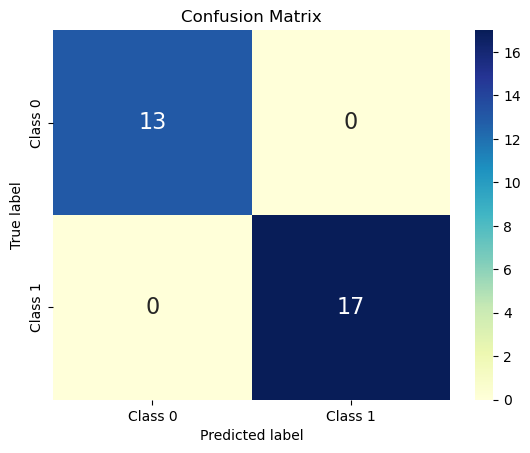

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

2-B performance evaluation


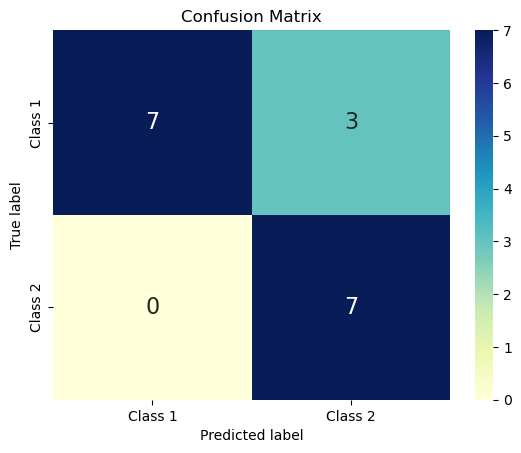

              precision    recall  f1-score   support

           1       1.00      0.70      0.82        10
           2       0.70      1.00      0.82         7

    accuracy                           0.82        17
   macro avg       0.85      0.85      0.82        17
weighted avg       0.88      0.82      0.82        17

Model net performance evaluation


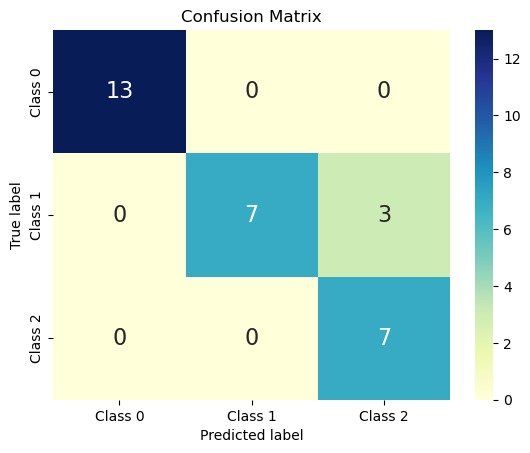

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.70      0.82        10
           2       0.70      1.00      0.82         7

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.88        30
weighted avg       0.93      0.90      0.90        30



In [106]:
# classifier 2-A alone
print("A performance evaluation")
perf_evaluate_plot(y_Final_test_A, y_Final_test_A_pred, model=1)

# classifier 2-B alone
print("2-B performance evaluation")
perf_evaluate_plot(y_Final_test_2_B, y_Final_test_2_B_pred, model=2)

# Net performance
print("Model net performance evaluation")
perf_evaluate_plot(Final_test_set["species"], Final_test_set["2_B_label"], model=3)

#### Final words

The result is pretty good at the first level (classifier A). However, we see some false negative for class 2 in the classifer 2-B which suggests that it can still be improved. The cause could be because we have introduced random labels into the dataset or due to information loss caused by taking average of each feature in the feature engineering step. The performance of the first level is perfect, so we do not see the error propagation effect which is a result of class 0 leaking into the second classifier that was not trained to classify them in this example, nevertheless, it has significant effect of the performance of the model when it happens. 

Anyways, the idea of this notebook is to demonstrate how to test different algorithms with hyperparameter tuning to train a model and how to evaluate a model that has two-level architecture which is a redacted version on my work on a very specific dataset on a totally unrelated topic.